In [1]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.
c:\users\ameya\.conda\envs\right\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ameya\.conda\envs\right\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ameya\.conda\envs\right\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ameya\.conda\envs\right\lib\site-packages\tenso

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir("C:\Jupyter\Audio_Data")
dir_list

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-01-02.wav',
 '03-01-01-01-01-01-03.wav',
 '03-01-01-01-01-01-04.wav',
 '03-01-01-01-01-01-05.wav',
 '03-01-01-01-01-01-06.wav',
 '03-01-01-01-01-01-07.wav',
 '03-01-01-01-01-01-08.wav',
 '03-01-01-01-01-01-09.wav',
 '03-01-01-01-01-01-10.wav',
 '03-01-01-01-01-01-11.wav',
 '03-01-01-01-01-01-12.wav',
 '03-01-01-01-01-01-13.wav',
 '03-01-01-01-01-01-14.wav',
 '03-01-01-01-01-01-15.wav',
 '03-01-01-01-01-01-16.wav',
 '03-01-01-01-01-01-17.wav',
 '03-01-01-01-01-01-18.wav',
 '03-01-01-01-01-01-19.wav',
 '03-01-01-01-01-01-20.wav',
 '03-01-01-01-01-01-21.wav',
 '03-01-01-01-01-01-22.wav',
 '03-01-01-01-01-01-23.wav',
 '03-01-01-01-01-01-24.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-01-02-02.wav',
 '03-01-01-01-01-02-03.wav',
 '03-01-01-01-01-02-04.wav',
 '03-01-01-01-01-02-05.wav',
 '03-01-01-01-01-02-06.wav',
 '03-01-01-01-01-02-07.wav',
 '03-01-01-01-01-02-08.wav',
 '03-01-01-01-01-02-09.wav',
 '03-01-01-01-01-02-10.wav',
 '03-01-01-01-

In [3]:
# Create DataFrame for Data intel

data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
file_list=os.listdir("C:\Jupyter\Audio_Data")
for f in file_list:
        nm = f.split('.')[0].split('-')
        path =  f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df


1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,03-01-01-01-01-01-02.wav,1,2,female,0,0,0,1
2,03-01-01-01-01-01-03.wav,1,3,male,0,0,0,1
3,03-01-01-01-01-01-04.wav,1,4,female,0,0,0,1
4,03-01-01-01-01-01-05.wav,1,5,male,0,0,0,1
...,...,...,...,...,...,...,...,...
1435,03-01-08-02-02-02-20.wav,1,20,female,1,1,1,8
1436,03-01-08-02-02-02-21.wav,1,21,male,1,1,1,8
1437,03-01-08-02-02-02-22.wav,1,22,female,1,1,1,8
1438,03-01-08-02-02-02-23.wav,1,23,male,1,1,1,8


In [5]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load("C:\Jupyter\Audio_Data"+"/"+data_df.path[1439])
sample_rate, samples

03-01-06-02-02-01-14.wav


(22050,
 array([0.        , 0.        , 0.        , ..., 0.00012568, 0.00013477,
        0.        ], dtype=float32))

In [6]:
len(samples), sample_rate

(80195, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [8]:
sample_rate/ len(samples)

0.2749547976806534

Text(0.5, 0, 'Seconds')

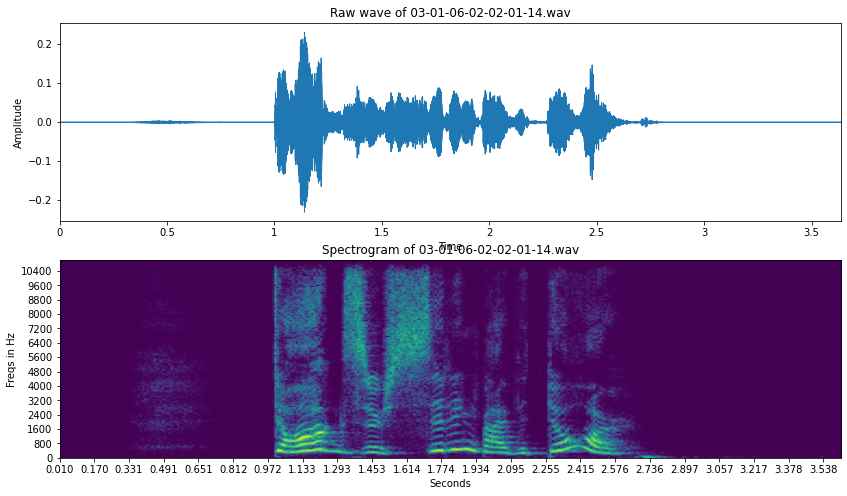

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

Text(0.5, 0, 'Seconds')

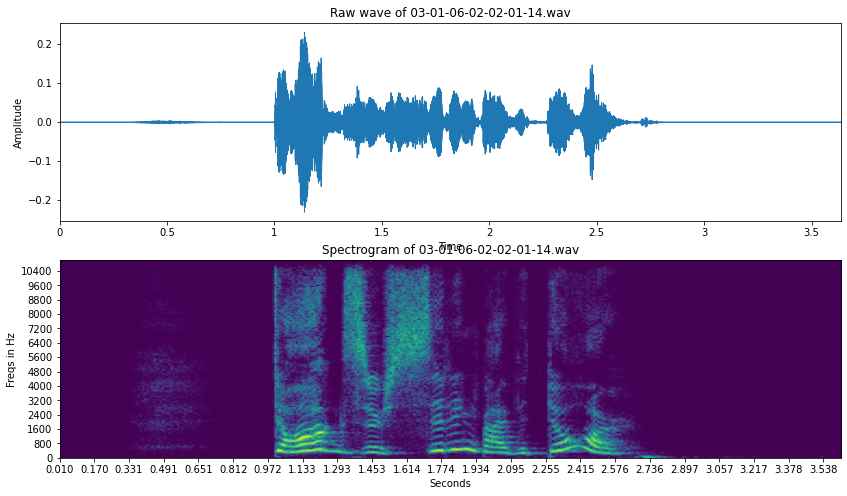

In [10]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [11]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [12]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-4.4005606e-05, -9.9295059e-05, -6.4618856e-05, ...,
        -6.6769513e-05, -5.4313150e-05, -6.9186310e-05], dtype=float32),
 array([21504, 61440]))

c:\users\ameya\.conda\envs\right\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning:

The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

c:\users\ameya\.conda\envs\right\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning:

The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



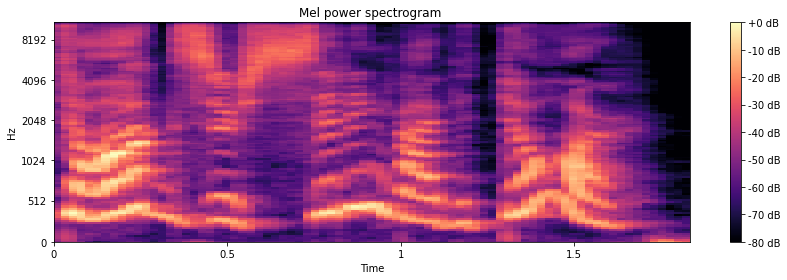

In [13]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

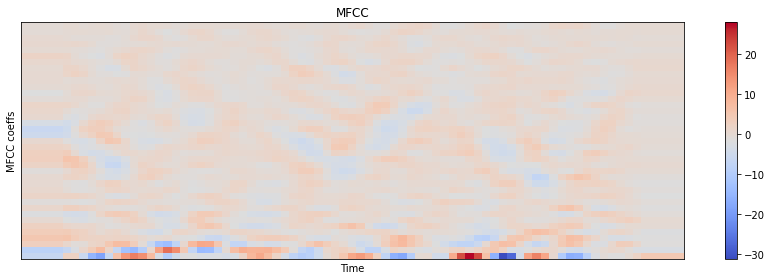

In [14]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=39)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [15]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [16]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [17]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [18]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [19]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [20]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [21]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [22]:
# Select the label set you want by commenting the unwanteds.

#data_df['label'] = label2_list
# data_df['label'] = label3_list
data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_none
1,03-01-01-01-01-01-02.wav,1,2,female,0,0,0,1,female_none
2,03-01-01-01-01-01-03.wav,1,3,male,0,0,0,1,male_none
3,03-01-01-01-01-01-04.wav,1,4,female,0,0,0,1,female_none
4,03-01-01-01-01-01-05.wav,1,5,male,0,0,0,1,male_none


In [23]:
print (data_df.label.value_counts().keys())

Index(['female_none', 'male_none', 'female_calm', 'male_sad', 'female_angry',
       'female_fearful', 'male_calm', 'male_fearful', 'female_sad',
       'female_happy', 'male_happy', 'male_angry'],
      dtype='object')


In [24]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

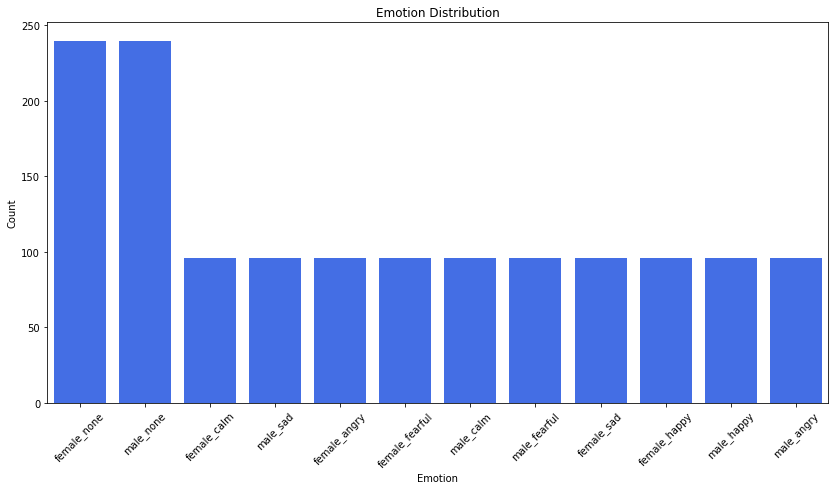

In [25]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [26]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
#data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
data2_df

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_calm
1,03-01-02-01-01-01-02.wav,1,2,female,0,0,0,2,female_calm
2,03-01-02-01-01-01-03.wav,1,3,male,0,0,0,2,male_calm
3,03-01-02-01-01-01-04.wav,1,4,female,0,0,0,2,female_calm
4,03-01-02-01-01-01-05.wav,1,5,male,0,0,0,2,male_calm
...,...,...,...,...,...,...,...,...,...
859,03-01-06-02-02-02-16.wav,1,16,female,1,1,1,6,female_fearful
860,03-01-06-02-02-02-18.wav,1,18,female,1,1,1,6,female_fearful
861,03-01-06-02-02-02-20.wav,1,20,female,1,1,1,6,female_fearful
862,03-01-06-02-02-02-22.wav,1,22,female,1,1,1,6,female_fearful


In [27]:
# Male Data Set

## Uncomment all below to use Male set 

#data2_df = data_df.copy()
#data2_df = data2_df[data2_df.label != "male_none"]
#data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
#data2_df = data2_df[data2_df.label != "female_neutral"]
#data2_df = data2_df[data2_df.label != "female_happy"]
#data2_df = data2_df[data2_df.label != "female_angry"]
#data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
#data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

#tmp1 = data2_df[data2_df.actor == 21]
#tmp2 = data2_df[data2_df.actor == 22]
#tmp3 = data2_df[data2_df.actor == 23]
#tmp4 = data2_df[data2_df.actor == 24]
#data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 21]
#data2_df = data2_df[data2_df.actor != 22]
#data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
#print (len(data2_df))
data2_df

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_calm
1,03-01-02-01-01-01-02.wav,1,2,female,0,0,0,2,female_calm
2,03-01-02-01-01-01-03.wav,1,3,male,0,0,0,2,male_calm
3,03-01-02-01-01-01-04.wav,1,4,female,0,0,0,2,female_calm
4,03-01-02-01-01-01-05.wav,1,5,male,0,0,0,2,male_calm
...,...,...,...,...,...,...,...,...,...
763,03-01-05-02-02-02-20.wav,1,20,female,1,1,1,5,female_angry
764,03-01-05-02-02-02-21.wav,1,21,male,1,1,1,5,male_angry
765,03-01-05-02-02-02-22.wav,1,22,female,1,1,1,5,female_angry
766,03-01-05-02-02-02-23.wav,1,23,male,1,1,1,5,male_angry


In [52]:
print (len(data2_df))
data2_df.head()

768


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_calm
1,03-01-02-01-01-01-02.wav,1,2,female,0,0,0,2,female_calm
2,03-01-02-01-01-01-03.wav,1,3,male,0,0,0,2,male_calm
3,03-01-02-01-01-01-04.wav,1,4,female,0,0,0,2,female_calm
4,03-01-02-01-01-01-05.wav,1,5,male,0,0,0,2,male_calm


In [82]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:\Jupyter\Audio_Data"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=1,sr=11025,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [00:13<00:00, 54.30it/s]


In [83]:
feature

array([-52.005825, -52.005825, -52.005825, -52.005825, -52.005825,
       -52.005825, -52.005825, -52.005825, -52.005825, -48.484337,
       -32.02621 , -25.132576, -28.015429, -35.216698, -37.729404,
       -39.08346 , -36.874985, -35.865112, -36.67436 , -39.279083,
       -41.662804, -42.86238 ], dtype=float32)

In [84]:
data

,feature
0,"[-69.609344, -69.609344, -69.609344, -69.60934..."
1,"[-61.723503, -58.155476, -54.018456, -53.71871..."
2,"[-66.27015, -66.27015, -66.27015, -66.27015, -..."
3,"[-67.55848, -67.51915, -66.59725, -66.58936, -..."
4,"[-58.293392, -59.842873, -57.528316, -53.99988..."
...,...
763,"[-49.667183, -49.656216, -49.14646, -48.879066..."
764,"[-48.577957, -48.577957, -48.577957, -48.16987..."
765,"[-48.331863, -47.48107, -46.535915, -43.861332..."
766,"[-41.658463, -41.658463, -41.658463, -41.65846..."


In [85]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [86]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-69.609344,-69.609344,-69.609344,-69.609344,-69.609344,-66.821625,-66.436913,-66.455681,-66.879120,-63.035927,...,-37.921745,-34.834442,-34.105423,-31.649702,-32.070168,-34.808548,-34.722889,-31.289328,-31.039978,-34.469204
1,-61.723503,-58.155476,-54.018456,-53.718716,-54.051025,-55.196342,-59.484806,-59.431660,-57.108864,-59.630466,...,-41.353035,-42.046608,-41.567074,-41.786160,-42.844944,-45.452583,-43.201656,-41.155273,-37.988480,-28.138092
2,-66.270149,-66.270149,-66.270149,-66.270149,-66.270149,-66.270149,-66.270149,-66.191719,-60.874184,-57.690517,...,-38.094475,-36.852207,-37.548519,-40.043255,-40.653301,-34.853245,-29.413937,-28.843464,-30.233753,-30.328182
3,-67.558479,-67.519150,-66.597252,-66.589363,-65.557549,-56.869259,-53.728725,-55.560101,-60.806011,-66.369186,...,-49.898232,-51.124634,-52.507675,-53.622078,-52.995869,-50.985088,-47.458656,-45.742607,-42.230507,-44.111015
4,-58.293392,-59.842873,-57.528316,-53.999886,-54.078533,-57.804756,-57.277122,-56.689079,-55.056942,-53.712547,...,-37.099716,-35.657749,-37.556522,-39.449455,-41.260288,-40.536171,-35.308331,-34.245640,-36.362106,-30.534885


In [77]:
newdf = pd.concat([df3,labels], axis=1)

In [78]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

768

In [79]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,male_calm
1,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,female_calm
2,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,male_calm
3,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,female_calm
4,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,male_calm
5,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,female_calm
6,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,male_calm
7,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,female_calm
8,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,male_calm
9,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-338.037872,-334.550446,...,-63.710579,-108.429306,-126.139915,-139.834839,-135.402161,-139.032349,-156.472137,-170.155975,-164.571228,female_calm


In [80]:
rnewdf.isnull().sum().sum()

0

In [127]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-23.203115,-23.203115,-23.203115,-23.203115,-23.203115,-22.044559,-22.044590,-22.038822,-21.993151,-21.492235,...,-19.958536,-20.850584,-22.457951,-23.166115,-22.889784,-22.437773,-22.121855,-22.864622,-23.039431,male_calm
1,-19.610657,-18.217386,-16.815710,-16.578262,-16.398083,-17.576532,-18.939606,-18.152229,-17.531385,-18.846901,...,-18.074696,-18.447531,-18.970001,-18.381222,-18.438345,-18.905863,-19.515011,-18.691759,-18.693251,female_calm
2,-22.090048,-22.090048,-22.090048,-22.090048,-22.090048,-22.090048,-22.090048,-21.522770,-18.910061,-18.991674,...,-16.455839,-17.809166,-18.812704,-19.084974,-18.226336,-18.202824,-18.180311,-18.873384,-19.419704,male_calm
3,-22.519491,-22.505409,-22.384207,-22.383392,-21.925026,-18.733965,-18.254408,-18.974695,-20.474335,-22.323528,...,-17.082970,-18.358692,-18.730705,-18.954353,-18.570160,-18.736950,-19.222261,-18.795572,-19.131874,female_calm
4,-17.364985,-18.209740,-16.307770,-14.674670,-15.118999,-16.965694,-17.283888,-16.712835,-15.992072,-15.275437,...,-15.712288,-15.535075,-15.669678,-16.342737,-16.989250,-16.138083,-17.292181,-18.167944,-17.227970,male_calm


In [128]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data



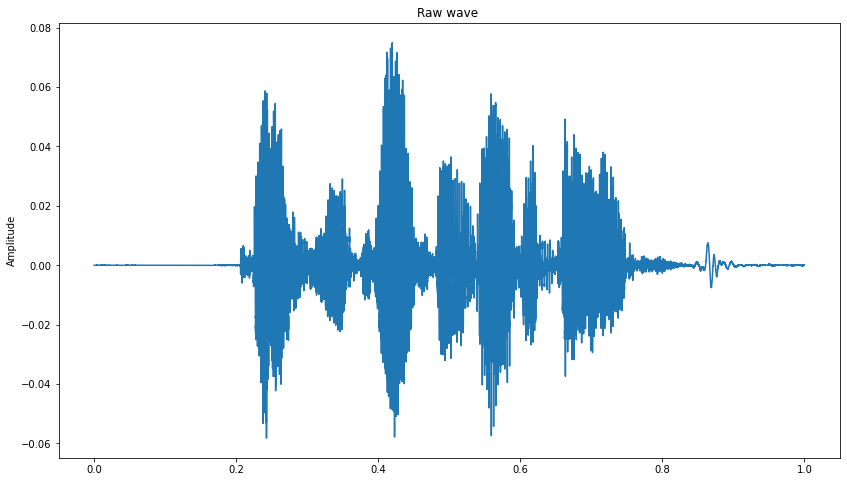

In [129]:
X, sample_rate = librosa.load("C:\Jupyter\Audio_Data"+"/"+data2_df.path[216], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

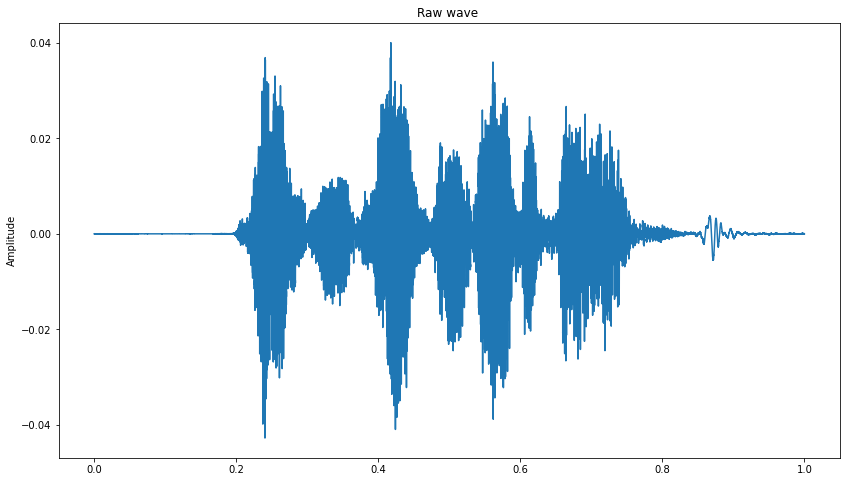

In [130]:
x = pitch(X,11025)
plot_time_series(x)
ipd.Audio(x, rate=11025) 

In [131]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:\Jupyter\Audio_Data"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=39), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [00:30<00:00, 25.37it/s]


In [132]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:\Jupyter\Audio_Data"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=39), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [01:07<00:00, 10.80it/s]


In [133]:
len(syn_data1), len(syn_data2) 

(768, 768)

In [134]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [135]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

768

In [136]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-17.397027,-17.034596,-17.092004,-16.894534,-16.503770,-16.492237,-17.129708,-17.049152,-16.737905,-16.739574,...,-16.200717,-16.451701,-16.930598,-17.473288,-16.766816,-16.630160,-17.053982,-16.657738,-16.217222,male_calm
1,-15.852824,-15.853588,-15.066712,-14.264466,-14.133438,-14.781332,-15.295906,-15.487610,-15.547337,-15.157222,...,-16.461863,-15.896568,-15.870648,-15.870610,-15.604394,-15.874029,-15.774274,-15.542935,-15.713269,female_calm
2,-21.377803,-20.739847,-20.157613,-20.510903,-21.157731,-20.565607,-20.003864,-18.907920,-18.240744,-18.602178,...,-16.342795,-17.771047,-18.337898,-18.778483,-17.502966,-17.662064,-17.761347,-18.537929,-19.491695,male_calm
3,-22.505708,-22.513369,-22.369709,-22.359355,-21.747437,-18.677365,-18.175050,-18.923718,-20.270947,-21.719395,...,-17.011766,-18.332451,-18.633914,-18.940121,-18.521243,-18.666504,-19.090632,-18.587182,-19.236258,female_calm
4,-15.411237,-16.334909,-14.998212,-13.396436,-13.772137,-15.240868,-15.605730,-15.211117,-15.083933,-14.548334,...,-15.408997,-15.397259,-15.161908,-15.500552,-16.337859,-15.541800,-16.221512,-16.607057,-16.050274,male_calm


In [137]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

768

In [138]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-24.971687,-24.971687,-24.955014,-24.648071,-24.035826,-23.210192,-22.937885,-23.205300,-23.151049,-21.833352,...,-22.415408,-22.720540,-23.209100,-24.337700,-24.433453,-24.065253,-23.768928,-23.956511,-24.528276,male_calm
1,-21.104682,-19.027328,-17.773188,-17.287655,-17.158651,-17.997739,-18.839543,-18.748190,-18.250997,-18.059070,...,-18.334082,-19.916292,-19.646984,-19.164139,-19.580407,-19.410374,-19.334330,-19.550851,-19.743807,female_calm
2,-22.702779,-22.702779,-22.702779,-22.702779,-22.702779,-22.702779,-22.664874,-22.702779,-20.123313,-17.644325,...,-17.332872,-18.717809,-19.452813,-19.666784,-19.944763,-19.180267,-18.730315,-19.421237,-20.286521,male_calm
3,-22.753371,-22.753371,-22.630625,-22.523901,-21.601541,-19.189343,-18.602435,-19.585897,-21.026825,-21.849592,...,-16.484735,-18.204229,-18.966826,-19.101982,-18.810483,-19.432833,-20.362660,-20.254861,-20.238868,female_calm
4,-17.413235,-18.007839,-16.127222,-15.063279,-15.810816,-17.274771,-17.374552,-17.088805,-16.463903,-15.424875,...,-15.945873,-16.808583,-17.605532,-17.522378,-17.403547,-16.916195,-17.539353,-18.060837,-19.042473,male_calm


In [139]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-23.203115,-23.203115,-23.203115,-23.203115,-23.203115,-22.044559,-22.044590,-22.038822,-21.993151,-21.492235,...,-19.958536,-20.850584,-22.457951,-23.166115,-22.889784,-22.437773,-22.121855,-22.864622,-23.039431,male_calm
1,-19.610657,-18.217386,-16.815710,-16.578262,-16.398083,-17.576532,-18.939606,-18.152229,-17.531385,-18.846901,...,-18.074696,-18.447531,-18.970001,-18.381222,-18.438345,-18.905863,-19.515011,-18.691759,-18.693251,female_calm
2,-22.090048,-22.090048,-22.090048,-22.090048,-22.090048,-22.090048,-22.090048,-21.522770,-18.910061,-18.991674,...,-16.455839,-17.809166,-18.812704,-19.084974,-18.226336,-18.202824,-18.180311,-18.873384,-19.419704,male_calm
3,-22.519491,-22.505409,-22.384207,-22.383392,-21.925026,-18.733965,-18.254408,-18.974695,-20.474335,-22.323528,...,-17.082970,-18.358692,-18.730705,-18.954353,-18.570160,-18.736950,-19.222261,-18.795572,-19.131874,female_calm
4,-17.364985,-18.209740,-16.307770,-14.674670,-15.118999,-16.965694,-17.283888,-16.712835,-15.992072,-15.275437,...,-15.712288,-15.535075,-15.669678,-16.342737,-16.989250,-16.138083,-17.292181,-18.167944,-17.227970,male_calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,-17.617282,-17.602414,-17.469214,-17.343653,-16.937120,-15.491513,-14.695318,-13.832983,-12.599136,-12.405903,...,-17.617282,-17.617282,-17.617282,-17.617282,-17.617282,-17.617282,-17.617282,-17.617282,-17.617282,female_angry
2300,-15.895959,-15.895959,-15.895959,-15.882785,-15.712662,-15.324922,-15.323437,-15.467665,-15.344828,-12.874191,...,-11.835969,-13.620676,-13.983334,-14.286734,-14.542104,-15.026668,-15.706490,-15.896200,-16.005041,male_angry
2301,-16.251902,-16.181373,-15.999851,-15.417975,-15.388035,-16.315280,-16.810017,-17.072541,-17.140018,-15.747219,...,-13.123320,-13.736415,-14.558247,-15.202449,-15.905228,-16.984959,-17.434378,-17.527887,-17.460443,female_angry
2302,-14.477684,-14.477684,-14.477684,-14.477684,-14.477684,-14.477684,-14.477684,-14.518085,-14.362955,-13.351587,...,-14.477684,-14.484477,-14.490439,-14.477684,-14.477684,0.000000,0.000000,0.000000,0.000000,male_angry


In [140]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label

from sklearn.utils import shuffle
#import numpy as np

X, y = shuffle(X, y)


xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [141]:
y_train.value_counts()

female_angry    231
male_angry      231
male_happy      231
female_happy    230
female_sad      230
male_calm       230
male_sad        230
female_calm     230
Name: label, dtype: int64

In [142]:
y_test.value_counts()

female_happy    58
female_sad      58
male_calm       58
male_sad        58
female_calm     58
female_angry    57
male_angry      57
male_happy      57
Name: label, dtype: int64

In [143]:
X_train.isna().sum().sum()

0

In [144]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train,y_train = shuffle(X_train,y_train)
X_test,y_test = shuffle(X_test,y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [145]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [146]:
X_train.shape

(1843, 65)

In [147]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [148]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


In [149]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters = 32,kernel_size=3,activation = 'relu',input_shape = (X_train.shape[1],1),padding ='same'),
                                    tf.keras.layers.MaxPool1D(pool_size = 2,strides = 2),
                      

                                    tf.keras.layers.Conv1D(filters = 64,kernel_size=3,activation = 'relu',padding='same'),
                                    

                                    tf.keras.layers.Conv1D(filters = 128,kernel_size=3,activation = 'relu',padding='same'),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.MaxPool1D(pool_size =2,strides = 2),

                                    #tf.keras.layers.Conv2D(filters = 256,kernel_size=3,activation = 'relu'),
                                    #tf.keras.layers.Dropout(0.1),

                                    #tf.keras.layers.Conv2D(filters = 512,kernel_size=3,activation = 'relu'),
                                    #tf.keras.layers.Dropout(0.1),
                                    #tf.keras.layers.MaxPool2D(pool_size =2),

                                    #tf.keras.layers.Conv2D(filters = 1024,kernel_size=3,activation = 'relu'),
                                    tf.keras.layers.MaxPool1D(pool_size =2,strides = 2),
                                    #tf.keras.layers.Dropout(0.1),

                                    

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(256,activation='relu'),
                                    

                            

                                    tf.keras.layers.Dense(8,activation='softmax')

                                      
                                    ])

In [150]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           24704     
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)            0         
__________

In [61]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', fscore])

In [62]:
# Model Training

#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.0001)
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=39,
                     validation_data=(x_testcnn, y_test))

Train on 1843 samples, validate on 461 samples
Epoch 1/39
1843/1843 [==============================] - ETA: 12:29 - loss: 3.6637 - acc: 0.0625 - fscore: 0.048 - ETA: 10:57 - loss: 5.9217 - acc: 0.0781 - fscore: 0.046 - ETA: 8:23 - loss: 5.9132 - acc: 0.0833 - fscore: 0.062 - ETA: 7:24 - loss: 5.9631 - acc: 0.1172 - fscore: 0.09 - ETA: 7:22 - loss: 6.2264 - acc: 0.1000 - fscore: 0.08 - ETA: 7:10 - loss: 5.9690 - acc: 0.1094 - fscore: 0.09 - ETA: 6:59 - loss: 5.7035 - acc: 0.1295 - fscore: 0.08 - ETA: 6:31 - loss: 5.6128 - acc: 0.1289 - fscore: 0.09 - ETA: 6:18 - loss: 5.4168 - acc: 0.1215 - fscore: 0.08 - ETA: 6:02 - loss: 5.2212 - acc: 0.1156 - fscore: 0.07 - ETA: 5:35 - loss: 5.0005 - acc: 0.1165 - fscore: 0.06 - ETA: 5:24 - loss: 4.8049 - acc: 0.1146 - fscore: 0.06 - ETA: 5:17 - loss: 4.6086 - acc: 0.1250 - fscore: 0.06 - ETA: 5:16 - loss: 4.4272 - acc: 0.1295 - fscore: 0.05 - ETA: 5:03 - loss: 4.2714 - acc: 0.1250 - fscore: 0.05 - ETA: 4:49 - loss: 4.1312 - acc: 0.1250 - fscore: 0.0

1843/1843 [==============================] - ETA: 4:02 - loss: 1.5968 - acc: 0.4375 - fscore: 0.15 - ETA: 5:27 - loss: 1.5177 - acc: 0.4531 - fscore: 0.18 - ETA: 6:59 - loss: 1.4647 - acc: 0.4583 - fscore: 0.16 - ETA: 6:21 - loss: 1.4042 - acc: 0.4766 - fscore: 0.22 - ETA: 5:47 - loss: 1.3840 - acc: 0.4813 - fscore: 0.22 - ETA: 5:49 - loss: 1.4230 - acc: 0.4531 - fscore: 0.24 - ETA: 6:08 - loss: 1.4084 - acc: 0.4509 - fscore: 0.24 - ETA: 5:37 - loss: 1.3882 - acc: 0.4609 - fscore: 0.25 - ETA: 5:22 - loss: 1.3793 - acc: 0.4549 - fscore: 0.26 - ETA: 5:15 - loss: 1.3745 - acc: 0.4594 - fscore: 0.27 - ETA: 5:07 - loss: 1.3702 - acc: 0.4631 - fscore: 0.28 - ETA: 4:55 - loss: 1.3794 - acc: 0.4505 - fscore: 0.27 - ETA: 4:53 - loss: 1.3546 - acc: 0.4639 - fscore: 0.28 - ETA: 4:38 - loss: 1.3405 - acc: 0.4777 - fscore: 0.29 - ETA: 4:31 - loss: 1.3310 - acc: 0.4854 - fscore: 0.30 - ETA: 4:27 - loss: 1.3287 - acc: 0.4844 - fscore: 0.30 - ETA: 4:29 - loss: 1.3214 - acc: 0.4871 - fscore: 0.31 - ETA

1843/1843 [==============================] - ETA: 6:06 - loss: 1.1339 - acc: 0.5938 - fscore: 0.55 - ETA: 6:04 - loss: 1.0723 - acc: 0.6094 - fscore: 0.54 - ETA: 5:32 - loss: 1.0736 - acc: 0.5833 - fscore: 0.47 - ETA: 5:30 - loss: 1.1231 - acc: 0.5547 - fscore: 0.45 - ETA: 6:06 - loss: 1.0876 - acc: 0.5687 - fscore: 0.49 - ETA: 6:06 - loss: 1.0709 - acc: 0.5677 - fscore: 0.50 - ETA: 5:38 - loss: 1.0409 - acc: 0.5848 - fscore: 0.52 - ETA: 5:33 - loss: 1.0585 - acc: 0.5781 - fscore: 0.52 - ETA: 5:41 - loss: 1.0562 - acc: 0.5764 - fscore: 0.52 - ETA: 5:36 - loss: 1.0663 - acc: 0.5813 - fscore: 0.52 - ETA: 5:19 - loss: 1.0656 - acc: 0.5824 - fscore: 0.51 - ETA: 5:01 - loss: 1.0837 - acc: 0.5703 - fscore: 0.50 - ETA: 4:48 - loss: 1.0909 - acc: 0.5697 - fscore: 0.50 - ETA: 4:59 - loss: 1.1042 - acc: 0.5625 - fscore: 0.49 - ETA: 4:44 - loss: 1.1196 - acc: 0.5542 - fscore: 0.49 - ETA: 4:44 - loss: 1.1177 - acc: 0.5566 - fscore: 0.49 - ETA: 4:34 - loss: 1.1191 - acc: 0.5551 - fscore: 0.49 - ETA

1843/1843 [==============================] - ETA: 3:27 - loss: 1.2478 - acc: 0.5000 - fscore: 0.45 - ETA: 4:22 - loss: 1.0033 - acc: 0.6562 - fscore: 0.59 - ETA: 4:18 - loss: 1.0233 - acc: 0.6562 - fscore: 0.59 - ETA: 4:23 - loss: 1.0657 - acc: 0.6094 - fscore: 0.56 - ETA: 5:03 - loss: 1.0792 - acc: 0.5875 - fscore: 0.55 - ETA: 5:01 - loss: 1.0525 - acc: 0.5938 - fscore: 0.55 - ETA: 4:45 - loss: 1.0220 - acc: 0.6161 - fscore: 0.56 - ETA: 4:24 - loss: 0.9927 - acc: 0.6328 - fscore: 0.58 - ETA: 4:37 - loss: 0.9724 - acc: 0.6424 - fscore: 0.58 - ETA: 4:22 - loss: 0.9655 - acc: 0.6531 - fscore: 0.59 - ETA: 4:34 - loss: 0.9748 - acc: 0.6420 - fscore: 0.58 - ETA: 4:24 - loss: 0.9607 - acc: 0.6380 - fscore: 0.57 - ETA: 4:26 - loss: 0.9594 - acc: 0.6346 - fscore: 0.57 - ETA: 4:26 - loss: 0.9476 - acc: 0.6362 - fscore: 0.58 - ETA: 4:17 - loss: 0.9503 - acc: 0.6312 - fscore: 0.58 - ETA: 4:12 - loss: 0.9516 - acc: 0.6309 - fscore: 0.58 - ETA: 4:04 - loss: 0.9770 - acc: 0.6232 - fscore: 0.57 - ETA

1843/1843 [==============================] - ETA: 5:26 - loss: 0.4652 - acc: 0.8750 - fscore: 0.83 - ETA: 5:24 - loss: 0.6526 - acc: 0.7812 - fscore: 0.76 - ETA: 5:34 - loss: 0.6518 - acc: 0.7917 - fscore: 0.78 - ETA: 5:43 - loss: 0.6695 - acc: 0.7812 - fscore: 0.76 - ETA: 5:31 - loss: 0.6685 - acc: 0.7875 - fscore: 0.78 - ETA: 5:27 - loss: 0.6666 - acc: 0.7708 - fscore: 0.76 - ETA: 5:11 - loss: 0.6609 - acc: 0.7634 - fscore: 0.75 - ETA: 5:11 - loss: 0.6688 - acc: 0.7578 - fscore: 0.75 - ETA: 5:05 - loss: 0.6617 - acc: 0.7708 - fscore: 0.74 - ETA: 4:46 - loss: 0.6484 - acc: 0.7750 - fscore: 0.75 - ETA: 4:41 - loss: 0.6392 - acc: 0.7756 - fscore: 0.75 - ETA: 4:31 - loss: 0.6385 - acc: 0.7786 - fscore: 0.75 - ETA: 4:26 - loss: 0.6388 - acc: 0.7837 - fscore: 0.75 - ETA: 4:25 - loss: 0.6425 - acc: 0.7812 - fscore: 0.74 - ETA: 4:26 - loss: 0.6405 - acc: 0.7812 - fscore: 0.74 - ETA: 4:15 - loss: 0.6403 - acc: 0.7832 - fscore: 0.74 - ETA: 4:11 - loss: 0.6586 - acc: 0.7776 - fscore: 0.74 - ETA

1843/1843 [==============================] - ETA: 6:46 - loss: 0.4763 - acc: 0.8438 - fscore: 0.85 - ETA: 4:43 - loss: 0.4811 - acc: 0.7969 - fscore: 0.81 - ETA: 5:35 - loss: 0.5673 - acc: 0.8021 - fscore: 0.80 - ETA: 5:54 - loss: 0.5703 - acc: 0.7891 - fscore: 0.78 - ETA: 5:59 - loss: 0.5348 - acc: 0.8125 - fscore: 0.80 - ETA: 5:50 - loss: 0.4861 - acc: 0.8333 - fscore: 0.82 - ETA: 5:58 - loss: 0.4959 - acc: 0.8304 - fscore: 0.82 - ETA: 5:29 - loss: 0.4894 - acc: 0.8320 - fscore: 0.82 - ETA: 5:10 - loss: 0.4740 - acc: 0.8368 - fscore: 0.83 - ETA: 4:49 - loss: 0.4963 - acc: 0.8281 - fscore: 0.82 - ETA: 4:59 - loss: 0.4867 - acc: 0.8295 - fscore: 0.82 - ETA: 4:52 - loss: 0.5206 - acc: 0.8177 - fscore: 0.81 - ETA: 4:38 - loss: 0.5283 - acc: 0.8149 - fscore: 0.81 - ETA: 4:24 - loss: 0.5073 - acc: 0.8214 - fscore: 0.81 - ETA: 4:18 - loss: 0.5085 - acc: 0.8167 - fscore: 0.81 - ETA: 4:03 - loss: 0.5160 - acc: 0.8145 - fscore: 0.81 - ETA: 4:02 - loss: 0.5235 - acc: 0.8088 - fscore: 0.80 - ETA

1843/1843 [==============================] - ETA: 5:05 - loss: 0.3555 - acc: 0.8750 - fscore: 0.84 - ETA: 6:01 - loss: 0.4071 - acc: 0.8438 - fscore: 0.83 - ETA: 6:25 - loss: 0.4466 - acc: 0.8229 - fscore: 0.81 - ETA: 6:03 - loss: 0.4602 - acc: 0.8281 - fscore: 0.81 - ETA: 5:10 - loss: 0.4073 - acc: 0.8562 - fscore: 0.84 - ETA: 5:17 - loss: 0.3675 - acc: 0.8802 - fscore: 0.86 - ETA: 5:30 - loss: 0.3678 - acc: 0.8795 - fscore: 0.87 - ETA: 5:45 - loss: 0.3717 - acc: 0.8711 - fscore: 0.86 - ETA: 5:29 - loss: 0.3688 - acc: 0.8715 - fscore: 0.85 - ETA: 5:22 - loss: 0.3525 - acc: 0.8781 - fscore: 0.86 - ETA: 5:22 - loss: 0.3641 - acc: 0.8750 - fscore: 0.86 - ETA: 5:11 - loss: 0.3578 - acc: 0.8750 - fscore: 0.86 - ETA: 5:02 - loss: 0.3528 - acc: 0.8750 - fscore: 0.86 - ETA: 4:43 - loss: 0.3543 - acc: 0.8750 - fscore: 0.86 - ETA: 4:38 - loss: 0.3672 - acc: 0.8625 - fscore: 0.85 - ETA: 4:35 - loss: 0.3767 - acc: 0.8594 - fscore: 0.84 - ETA: 4:35 - loss: 0.3750 - acc: 0.8585 - fscore: 0.84 - ETA

1843/1843 [==============================] - ETA: 2:58 - loss: 0.2220 - acc: 0.9688 - fscore: 0.91 - ETA: 4:23 - loss: 0.2039 - acc: 0.9375 - fscore: 0.91 - ETA: 5:44 - loss: 0.2474 - acc: 0.9167 - fscore: 0.89 - ETA: 5:15 - loss: 0.2559 - acc: 0.9141 - fscore: 0.89 - ETA: 4:58 - loss: 0.2703 - acc: 0.9000 - fscore: 0.88 - ETA: 5:12 - loss: 0.2788 - acc: 0.8958 - fscore: 0.88 - ETA: 5:19 - loss: 0.2621 - acc: 0.9062 - fscore: 0.89 - ETA: 5:18 - loss: 0.2813 - acc: 0.8984 - fscore: 0.88 - ETA: 5:07 - loss: 0.2755 - acc: 0.9028 - fscore: 0.89 - ETA: 5:13 - loss: 0.2658 - acc: 0.9062 - fscore: 0.89 - ETA: 5:00 - loss: 0.2673 - acc: 0.9006 - fscore: 0.89 - ETA: 5:01 - loss: 0.2550 - acc: 0.9089 - fscore: 0.90 - ETA: 4:59 - loss: 0.2555 - acc: 0.9111 - fscore: 0.90 - ETA: 4:50 - loss: 0.2513 - acc: 0.9129 - fscore: 0.90 - ETA: 4:37 - loss: 0.2483 - acc: 0.9146 - fscore: 0.91 - ETA: 4:26 - loss: 0.2539 - acc: 0.9121 - fscore: 0.90 - ETA: 4:24 - loss: 0.2585 - acc: 0.9099 - fscore: 0.90 - ETA

1843/1843 [==============================] - ETA: 3:44 - loss: 0.3050 - acc: 0.8438 - fscore: 0.84 - ETA: 4:16 - loss: 0.2762 - acc: 0.8594 - fscore: 0.86 - ETA: 4:48 - loss: 0.2482 - acc: 0.8854 - fscore: 0.88 - ETA: 4:59 - loss: 0.2402 - acc: 0.8828 - fscore: 0.88 - ETA: 5:08 - loss: 0.2280 - acc: 0.8938 - fscore: 0.89 - ETA: 4:46 - loss: 0.2071 - acc: 0.9062 - fscore: 0.91 - ETA: 5:22 - loss: 0.1985 - acc: 0.9152 - fscore: 0.91 - ETA: 5:20 - loss: 0.1915 - acc: 0.9219 - fscore: 0.92 - ETA: 5:13 - loss: 0.2004 - acc: 0.9201 - fscore: 0.91 - ETA: 5:17 - loss: 0.1959 - acc: 0.9250 - fscore: 0.92 - ETA: 5:04 - loss: 0.1958 - acc: 0.9261 - fscore: 0.92 - ETA: 5:00 - loss: 0.2221 - acc: 0.9115 - fscore: 0.90 - ETA: 4:56 - loss: 0.2138 - acc: 0.9183 - fscore: 0.91 - ETA: 4:50 - loss: 0.2111 - acc: 0.9219 - fscore: 0.91 - ETA: 4:40 - loss: 0.2144 - acc: 0.9229 - fscore: 0.91 - ETA: 4:38 - loss: 0.2311 - acc: 0.9141 - fscore: 0.90 - ETA: 4:40 - loss: 0.2281 - acc: 0.9154 - fscore: 0.91 - ETA

1843/1843 [==============================] - ETA: 2:40 - loss: 0.0515 - acc: 1.0000 - fscore: 1.00 - ETA: 4:39 - loss: 0.0688 - acc: 0.9844 - fscore: 0.99 - ETA: 5:11 - loss: 0.1005 - acc: 0.9792 - fscore: 0.98 - ETA: 5:27 - loss: 0.0916 - acc: 0.9844 - fscore: 0.98 - ETA: 4:53 - loss: 0.0850 - acc: 0.9875 - fscore: 0.99 - ETA: 4:51 - loss: 0.1017 - acc: 0.9688 - fscore: 0.97 - ETA: 4:55 - loss: 0.0955 - acc: 0.9688 - fscore: 0.97 - ETA: 4:57 - loss: 0.1032 - acc: 0.9688 - fscore: 0.97 - ETA: 4:57 - loss: 0.1036 - acc: 0.9618 - fscore: 0.96 - ETA: 4:56 - loss: 0.0977 - acc: 0.9656 - fscore: 0.96 - ETA: 5:05 - loss: 0.0956 - acc: 0.9688 - fscore: 0.96 - ETA: 4:51 - loss: 0.0910 - acc: 0.9714 - fscore: 0.96 - ETA: 4:47 - loss: 0.0912 - acc: 0.9736 - fscore: 0.97 - ETA: 4:37 - loss: 0.0866 - acc: 0.9754 - fscore: 0.97 - ETA: 4:29 - loss: 0.0882 - acc: 0.9729 - fscore: 0.97 - ETA: 4:21 - loss: 0.0904 - acc: 0.9707 - fscore: 0.96 - ETA: 4:15 - loss: 0.0936 - acc: 0.9688 - fscore: 0.96 - ETA

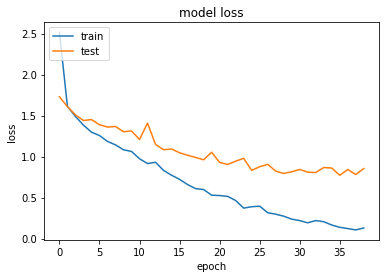

In [76]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

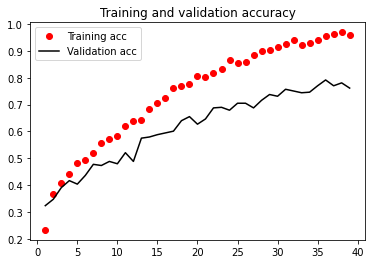

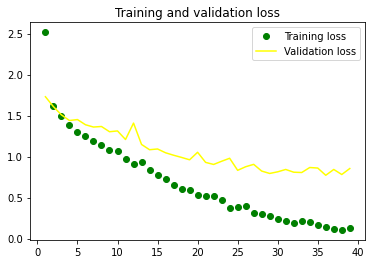

<Figure size 432x288 with 0 Axes>

In [92]:
#from keras.callbacks import History 
#history = History()
epochs = 39

train_loss = cnnhistory.history['loss']
val_loss   = cnnhistory.history['val_loss']
train_acc  = cnnhistory.history['acc']
val_acc    = cnnhistory.history['val_acc']
xc         = range(epochs)


import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training acc',color ='r')
plt.plot(epochs, val_acc, 'b', label='Validation acc',color='black')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss',color='green')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='yellow')
plt.title('Training and validation loss')
plt.legend()

plt.show()

plt.savefig('Train vs Test.png')

In [77]:
score =model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 76.14%


In [78]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

461/461 [==============================] - ETA:  - 0s 78us/step


In [79]:
preds

array([[6.55297105e-09, 1.55362429e-07, 4.16285184e-09, ...,
        4.26028788e-01, 3.19907606e-01, 2.28236511e-01],
       [4.71774369e-01, 1.67034252e-03, 2.47390522e-03, ...,
        1.34689947e-06, 2.90947219e-06, 5.40045148e-04],
       [6.21725917e-01, 3.77446443e-01, 6.18407852e-04, ...,
        9.02352554e-07, 1.59832834e-05, 1.68625396e-04],
       ...,
       [2.50348169e-08, 4.29075335e-05, 2.12026475e-06, ...,
        4.84949615e-11, 2.98275612e-03, 5.21754585e-02],
       [5.50928831e-01, 3.33196133e-01, 5.85051551e-02, ...,
        1.20083932e-05, 1.13605552e-06, 4.78132351e-05],
       [1.41869404e-03, 1.09042515e-11, 9.53223169e-01, ...,
        9.78122465e-04, 3.14581757e-06, 3.64312700e-06]], dtype=float32)

In [80]:
preds1=preds.argmax(axis=1)

In [81]:
preds1

array([5, 3, 0, 7, 7, 7, 6, 3, 1, 3, 2, 6, 5, 5, 4, 6, 7, 4, 1, 0, 2, 1,
       0, 2, 0, 0, 4, 0, 3, 4, 3, 6, 1, 3, 2, 5, 6, 1, 0, 0, 3, 4, 3, 3,
       4, 6, 1, 5, 7, 2, 3, 6, 1, 4, 2, 6, 6, 6, 5, 3, 6, 6, 0, 2, 3, 1,
       5, 3, 0, 2, 3, 5, 0, 4, 6, 2, 5, 4, 3, 5, 6, 7, 5, 7, 0, 3, 6, 1,
       4, 4, 5, 7, 3, 6, 7, 6, 6, 4, 4, 2, 6, 7, 7, 1, 5, 6, 5, 1, 3, 4,
       0, 1, 1, 0, 6, 6, 6, 1, 1, 0, 4, 7, 7, 5, 3, 3, 0, 0, 6, 2, 6, 5,
       3, 2, 2, 4, 6, 2, 2, 0, 7, 3, 6, 2, 6, 4, 5, 5, 1, 2, 5, 7, 2, 4,
       7, 3, 3, 0, 3, 2, 5, 1, 7, 0, 1, 7, 7, 0, 6, 5, 5, 6, 6, 2, 0, 4,
       5, 3, 4, 0, 4, 5, 6, 5, 0, 0, 5, 2, 0, 3, 4, 0, 1, 7, 3, 4, 0, 1,
       2, 7, 3, 1, 0, 5, 7, 5, 1, 5, 3, 5, 1, 1, 2, 5, 4, 2, 0, 4, 3, 6,
       5, 3, 6, 5, 5, 2, 0, 3, 6, 5, 5, 3, 5, 1, 0, 5, 1, 6, 6, 6, 2, 3,
       4, 5, 6, 4, 2, 7, 0, 6, 7, 1, 4, 3, 0, 7, 0, 3, 4, 4, 1, 3, 4, 5,
       6, 7, 7, 7, 7, 3, 6, 2, 0, 1, 5, 2, 7, 1, 0, 4, 5, 4, 4, 0, 5, 4,
       7, 7, 4, 5, 5, 5, 0, 2, 3, 2, 3, 2, 4, 1, 6,

In [82]:
abc = preds1.astype(int).flatten()

predictions = (lb.inverse_transform((abc)))

preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]


actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

finaldf = actualdf.join(preddf)

In [83]:
finaldf

,actualvalues,predictedvalues
0,male_sad,male_calm
1,female_angry,female_sad
2,female_calm,female_angry
3,female_calm,male_sad
4,male_sad,male_sad
...,...,...
456,female_happy,female_happy
457,male_angry,male_angry
458,female_sad,female_sad
459,female_angry,female_angry


In [84]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,57
female_calm,58
female_happy,58
female_sad,58
male_angry,57
male_calm,58
male_happy,57
male_sad,58


In [85]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,58
female_calm,39
female_happy,59
female_sad,57
male_angry,63
male_calm,69
male_happy,64
male_sad,52


In [86]:
finaldf.to_csv('Predictions.csv', index=False)

In [87]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*10

7.613882863340564

In [88]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

75.89707764462102